In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
Data = pd.read_excel("/content/gdrive/MyDrive/Sem 4 project/Online Retail_2.xlsx",sheet_name="Preprocessed Online Retail")
Data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,581587,22631,CIRCUS PARADE LUNCH BOX,12,2011-12-09 12:50:00,1.95,12680,France,23.4
1,581587,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-12-09 12:50:00,1.65,12680,France,19.8
2,581587,22555,PLASTERS IN TIN STRONGMAN,12,2011-12-09 12:50:00,1.65,12680,France,19.8
3,581587,22728,ALARM CLOCK BAKELIKE PINK,4,2011-12-09 12:50:00,3.75,12680,France,15.0
4,581587,22727,ALARM CLOCK BAKELIKE RED,4,2011-12-09 12:50:00,3.75,12680,France,15.0


In [ ]:
!pip install lifetimes

     |████████████████████████████████| 593kB 8.5MB/s 


In [ ]:
from lifetimes.plotting import *
from lifetimes.utils import *

In [ ]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397884 entries, 0 to 397883
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  int64         
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  int64         
 7   Country      397884 non-null  object        
 8   Sales        397884 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 27.3+ MB


In [ ]:
#?summary_data_from_transaction_data
Data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Sales'],
      dtype='object')

In [ ]:
RFM = summary_data_from_transaction_data(Data,customer_id_col='StockCode',
                                         datetime_col='InvoiceDate',
                                         monetary_value_col='Sales',
                                         observation_period_end=Data['InvoiceDate'].max())
RFM=RFM.drop(columns='T')

RFM.head()

,frequency,recency,monetary_value
StockCode,,,
10002,36.0,138.0,18.015278
10080,19.0,267.0,5.932105
10120,23.0,366.0,1.734783
10125,46.0,373.0,20.186957
10133,77.0,280.0,14.796883


In [ ]:
stats=RFM.describe().T
stats

,count,mean,std,min,25%,50%,75%,max
frequency,3665.0,59.673943,62.730717,0.0,10.00,38.000000,89.000000,304.0
recency,3665.0,264.976808,126.035046,0.0,173.00,337.000000,369.000000,373.0
monetary_value,3665.0,26.756886,60.436423,0.0,8.75,15.981395,28.580843,2730.0


In [ ]:
int(stats['min'][0])

0

In [ ]:
# Define rfm_level function
def F_score(df):
    if df['frequency'] == stats['min'][0]:
        return int(1)
    elif ((stats['25%'][0]>= df['frequency']) and (stats['25%'][0]<df['frequency'])):
        return int(2)
    elif ((stats['50%'][0]>=df['frequency']) and (stats['50%'][0]<df['frequency'])):
        return int(3)
    elif ((stats['75%'][0]>=df['frequency']) and (stats['75%'][0]<df['frequency'])):
        return int(4)
    

In [ ]:
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 5)

# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(RFM['recency'], q=4, labels=r_labels)

# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(RFM['frequency'], q=4, labels=f_labels)

# Create new columns R and F 
RFM = RFM.assign(R = r_groups.values, F = f_groups.values)

# Create labels for MonetaryValue
m_labels = range(1, 5)

# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(RFM['monetary_value'], q=4, labels=m_labels)

# Create new column M
RFM = RFM.assign(M = m_groups.values)


RFM = RFM[['frequency','recency','monetary_value','R','F','M']].astype('int32')
RFM['RFM_Score']= RFM['R'] + RFM['F'] +RFM['M']
RFM.head()


,frequency,recency,monetary_value,R,F,M,RFM_Score
StockCode,,,,,,,
10002,36,138,18,4,2,3,9
10080,19,267,5,3,2,1,6
10120,23,366,1,2,2,1,5
10125,46,373,20,1,3,3,7
10133,77,280,14,3,3,2,8


In [ ]:
#RFM.to_csv('RFM of StockCode.csv')
#from google.colab import files
#files.download('RFM of StockCode.csv')

In [ ]:
df = pd.merge(RFM,Data,on="StockCode")
df.head()

,StockCode,frequency,recency,monetary_value,R,F,M,RFM_Score,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,10002,36,138,18,4,2,3,9,550452,INFLATABLE POLITICAL GLOBE,1,2011-04-18 12:56:00,0.85,14525,United Kingdom,0.85
1,10002,36,138,18,4,2,3,9,550272,INFLATABLE POLITICAL GLOBE,62,2011-04-15 12:14:00,0.85,18079,United Kingdom,52.70
2,10002,36,138,18,4,2,3,9,548714,INFLATABLE POLITICAL GLOBE,2,2011-04-03 15:07:00,0.85,17337,United Kingdom,1.70
3,10002,36,138,18,4,2,3,9,548702,INFLATABLE POLITICAL GLOBE,4,2011-04-03 11:36:00,0.85,17085,United Kingdom,3.40
4,10002,36,138,18,4,2,3,9,548606,INFLATABLE POLITICAL GLOBE,120,2011-04-01 11:10:00,0.85,12731,France,102.00


In [ ]:
feature_df = df.pivot_table(index='Description',columns='CustomerID',values='RFM_Score').fillna(0)
feature_df.head()

CustomerID,12346,12347,12348,12349,12350,12352,12353,12354,12355,12356,12357,12358,12359,12360,12361,12362,12363,12364,12365,12367,12370,12371,12372,12373,12374,12375,12377,12378,12379,12380,12381,12383,12384,12386,12388,12390,12391,12393,12394,12395,...,18230,18231,18232,18233,18235,18236,18237,18239,18240,18241,18242,18245,18246,18248,18249,18250,18251,18252,18255,18257,18259,18260,18261,18262,18263,18265,18268,18269,18270,18272,18273,18274,18276,18277,18278,18280,18281,18282,18283,18287
Description,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4 PURPLE FLOCK DINNER CANDLES,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50'S CHRISTMAS GIFT BAG LARGE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DOLLY GIRL BEAKER,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I LOVE LONDON MINI BACKPACK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I LOVE LONDON MINI RUCKSACK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from scipy.sparse import csr_matrix

feature_df_matrix = csr_matrix(feature_df.values)

from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric ='cosine', algorithm = 'brute')
model_knn.fit(feature_df_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
feature_df.shape

(3877, 4338)

In [ ]:
feature_df.index

Index([' 4 PURPLE FLOCK DINNER CANDLES', ' 50'S CHRISTMAS GIFT BAG LARGE',
       ' DOLLY GIRL BEAKER', ' I LOVE LONDON MINI BACKPACK',
       ' I LOVE LONDON MINI RUCKSACK', ' NINE DRAWER OFFICE TIDY',
       ' OVAL WALL MIRROR DIAMANTE ', ' RED SPOT GIFT BAG LARGE',
       ' SET 2 TEA TOWELS I LOVE LONDON ', ' SPACEBOY BABY GIFT SET',
       ...
       'ZINC STAR T-LIGHT HOLDER ', 'ZINC SWEETHEART SOAP DISH',
       'ZINC SWEETHEART WIRE LETTER RACK', 'ZINC T-LIGHT HOLDER STAR LARGE',
       'ZINC T-LIGHT HOLDER STARS LARGE', 'ZINC T-LIGHT HOLDER STARS SMALL',
       'ZINC TOP  2 DOOR WOODEN SHELF ', 'ZINC WILLIE WINKIE  CANDLE STICK',
       'ZINC WIRE KITCHEN ORGANISER', 'ZINC WIRE SWEETHEART LETTER TRAY'],
      dtype='object', name='Description', length=3877)

In [ ]:
names = pd.DataFrame({"SR.No": range(0,feature_df.shape[0]) , "Items":feature_df.index})
names.head()

,SR.No,Items
0,0,4 PURPLE FLOCK DINNER CANDLES
1,1,50'S CHRISTMAS GIFT BAG LARGE
2,2,DOLLY GIRL BEAKER
3,3,I LOVE LONDON MINI BACKPACK
4,4,I LOVE LONDON MINI RUCKSACK


In [ ]:
#names[names['Items'] == "DOLLY GIRL BEAKER"]["SR.No"]

#names.loc[names["Items"] == "DOLLY GIRL BEAKER", "SR.No"]

names[names['Items'].isin(['DOLLY GIRL BEAKER'])]

,SR.No,Items


In [ ]:
query_index = np.random.choice(feature_df.shape[0])
print("Randomly Selected index number is : ", query_index , "\nAnd the corresponding product name is :", feature_df.index[query_index])

Randomly Selected index number is :  2137 
And the corresponding product name is : NECKLACE+BRACELET PINK BUTTERFLY


In [ ]:

distances, indices = model_knn.kneighbors(feature_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)
 

for i in range(0,len(distances.flatten())):
   if i == 0 :
    print("Recommendations for Product : " , feature_df.index[query_index])
   else:
    print(i , ":" , feature_df.index[indices.flatten()[i]] , "with cosine distance of " , distances.flatten()[i])

Recommendations for Product :  NECKLACE+BRACELET PINK BUTTERFLY
1 : WHITE ROSEBUD  PEARL EARRINGS with cosine distance of  0.6666666666666667
2 : BAROQUE BUTTERFLY EARRINGS CRYSTAL with cosine distance of  0.6666666666666667
3 : TINY CRYSTAL BRACELET GREEN with cosine distance of  0.6666666666666667
4 : LETTER "F" BLING KEY RING with cosine distance of  0.7642977396044841
5 : BLUE TEATIME PRINT BOWL  with cosine distance of  0.7642977396044841


In [ ]:

distances, indices = model_knn.kneighbors(feature_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)
 
names=[]
cosine=[]
for i in range(0,len(distances.flatten())):
   if i == 0 :
    print("Recommendations for Product : " , feature_df.index[query_index])
   else:
     names.append(feature_df.index[indices.flatten()[i]])
     cosine.append(distances.flatten()[i])
     recommendation = pd.DataFrame({"Names" : names , "distance" : cosine })
     
    #  print(i , ":" , feature_df.index[indices.flatten()[i]] , "with cosine distance of " , distances.flatten()[i])

recommendation=recommendation.sort_values(by='distance', ascending=False, ignore_index= True)
recommendation

Recommendations for Product :  NECKLACE+BRACELET PINK BUTTERFLY


,Names,distance
0,"LETTER ""F"" BLING KEY RING",0.764298
1,BLUE TEATIME PRINT BOWL,0.764298
2,WHITE ROSEBUD PEARL EARRINGS,0.666667
3,BAROQUE BUTTERFLY EARRINGS CRYSTAL,0.666667
4,TINY CRYSTAL BRACELET GREEN,0.666667


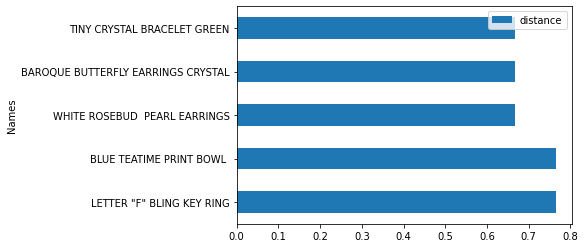

In [ ]:
recommendation.plot.barh(x="Names",y="distance")

**Note Point**

This Cosine similarity score ranges from 0 to 1, with 0 being the lowest (the least similar) and 1 being the highest (the most similar).

#**Extra EDA**

In [ ]:
ratings = pd.DataFrame(df.groupby('Description')['RFM_Score'].mean())
ratings.head()

,RFM_Score
Description,
4 PURPLE FLOCK DINNER CANDLES,4.0
50'S CHRISTMAS GIFT BAG LARGE,11.0
DOLLY GIRL BEAKER,11.0
I LOVE LONDON MINI BACKPACK,11.0
I LOVE LONDON MINI RUCKSACK,11.0


In [ ]:
ratings['Number of ratings'] = pd.DataFrame(df.groupby('Description')['RFM_Score'].count())
ratings.head()

,RFM_Score,Number of ratings
Description,,
4 PURPLE FLOCK DINNER CANDLES,4.0,39
50'S CHRISTMAS GIFT BAG LARGE,11.0,109
DOLLY GIRL BEAKER,11.0,138
I LOVE LONDON MINI BACKPACK,11.0,70
I LOVE LONDON MINI RUCKSACK,11.0,1


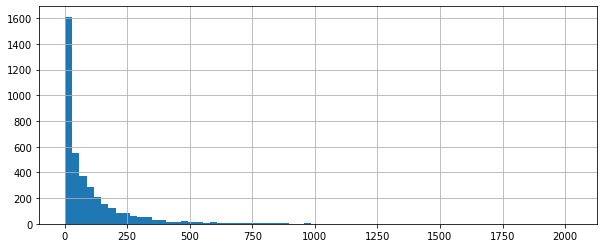

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
ratings['Number of ratings'].hist(bins=70)

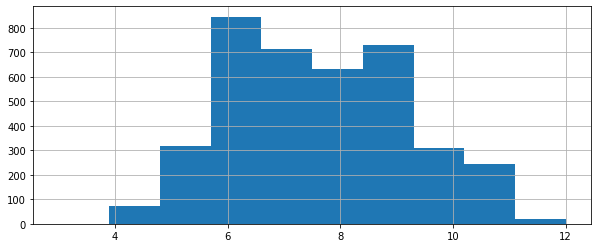

In [ ]:

plt.figure(figsize=(10,4))
ratings['RFM_Score'].hist()

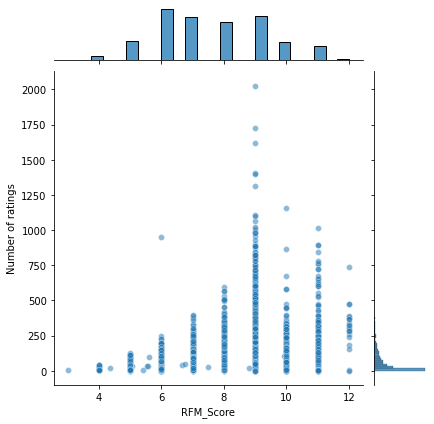

In [ ]:
import seaborn as sns
sns.jointplot(x='RFM_Score',y='Number of ratings',data=ratings,alpha=0.5,kind='scatter')

#**Recommendations Computation by Different Metrics**

In [ ]:
query_index = np.random.choice(feature_df.shape[0])
print("Randomly Selected index number is : ", query_index , "\nAnd the corresponding product name is :", feature_df.index[query_index])

Randomly Selected index number is :  984 
And the corresponding product name is : DOLLCRAFT GIRL AMELIE KIT


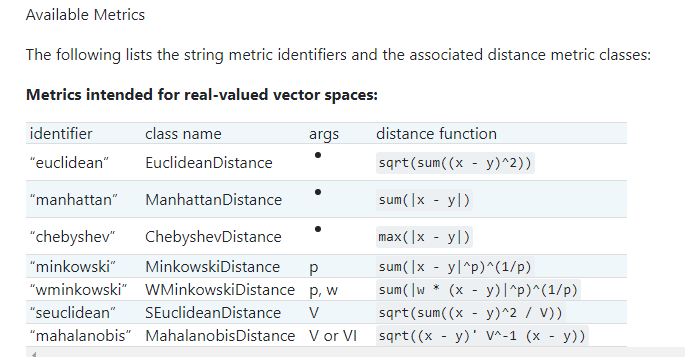

In [ ]:
distances=['euclidean','manhattan','minkowski','cosine']

for i in distances:
  feature_df_matrix = csr_matrix(feature_df.values)
  model_knn = NearestNeighbors(metric =str(i), algorithm = 'brute')
  model_knn.fit(feature_df_matrix)

  distances, indices = model_knn.kneighbors(feature_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

  print("\nCalculating Reccomendations by " + str(i) + " distance metric ")
 

  for j in range(0,len(distances.flatten())):
    if j == 0 :
      print("\nRecommendations for Product : " , feature_df.index[query_index])
    else:
      print(j , ":" , feature_df.index[indices.flatten()[j]] , "with " + str(i) + " distance of" , round(distances.flatten()[j],3))

      


Calculating Reccomendations by euclidean distance metric 

Recommendations for Product :  DOLLCRAFT GIRL AMELIE KIT
1 :  I LOVE LONDON MINI RUCKSACK with euclidean distance of 29.103
2 : SET 36 COLOURING PENCILS DOILEY with euclidean distance of 29.103
3 : SET 12 COLOURING PENCILS DOILEY with euclidean distance of 29.12
4 : DOLLCRAFT BOY JEAN-PAUL  with euclidean distance of 29.12
5 : FOLDING MIRROR IVORY  with euclidean distance of 30.199

Calculating Reccomendations by manhattan distance metric 

Recommendations for Product :  DOLLCRAFT GIRL AMELIE KIT
1 :  I LOVE LONDON MINI RUCKSACK with manhattan distance of 77.0
2 : SET 36 COLOURING PENCILS DOILEY with manhattan distance of 77.0
3 : SET 12 COLOURING PENCILS DOILEY with manhattan distance of 78.0
4 : CANNISTER VINTAGE LEAF DESIGN with manhattan distance of 88.0
5 : DOLLCRAFT BOY JEAN-PAUL  with manhattan distance of 88.0

Calculating Reccomendations by minkowski distance metric 

Recommendations for Product :  DOLLCRAFT GIRL AMEL

# Recommendations by Correlation Matrix of items purchased

In [ ]:
Corr_Matrix=feature_df.T.corr()

In [ ]:
def Corr_matrix_suggestions(product_name):
  suggestions = Corr_Matrix[product_name].sort_values(ascending=False)

  return suggestions


In [ ]:
Corr_matrix_suggestions('FAIRY TALE COTTAGE NIGHTLIGHT')

Description
FAIRY TALE COTTAGE NIGHTLIGHT       1.000000
RED TOADSTOOL LED NIGHT LIGHT       0.266292
WOODLAND PARTY BAG + STICKER SET    0.210072
RABBIT NIGHT LIGHT                  0.201365
PACK OF 12 DOILEY TISSUES           0.196907
                                      ...   
METAL SIGN DROP YOUR PANTS         -0.018865
CREAM HEART CARD HOLDER            -0.019529
HOME SWEET HOME CUSHION COVER      -0.021688
VINTAGE CREAM DOG FOOD CONTAINER   -0.022429
LARGE WHITE HEART OF WICKER        -0.024459
Name: FAIRY TALE COTTAGE NIGHTLIGHT, Length: 3877, dtype: float64